## Tutorial 3: Running spatially distributed simulations

In [17]:
import xarray as xr
import pysumma as ps
import geopandas as gpd
import pysumma.plotting as psp
import matplotlib.pyplot as plt
!cd data/yakima && ./install_local_setup.sh && cd -

/pool0/data/andrbenn/workspace/pysumma-tutorial


In [18]:
summa_exe = 'summa.exe'
file_manager = './data/yakima/file_manager.txt'
shapefile = './data/yakima/shapefile/yakima.shp'
gdf = gpd.GeoDataFrame.from_file(shapefile)

In [3]:
yakima = ps.Distributed(summa_exe, file_manager, num_workers=8, num_chunks=8)

/pool0/data/andrbenn/.conda/all/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35356 instead
  http_address["port"], self.http_server.port


In [4]:
yakima.run('local')

In [8]:
success = []
failure = []
out_ds = []

for n, sim in yakima.simulations.items():
    if sim.status == 'Success':
        success.append(n)
        out_ds.append( sim.output.load())
    else:
        failure.append(n)
    

In [25]:
hru_vars = [] # variables that have hru dimension
gru_vars = [] # variables that have gru dimension
for name, var in out_ds[0].variables.items():
    if 'hru' in var.dims:
        hru_vars.append(name)
    elif 'gru' in var.dims:
        gru_vars.append(name)
hru_ds = [ds[hru_vars] for ds in out_ds]
gru_ds = [ds[gru_vars] for ds in out_ds]
hru_merged = xr.concat(hru_ds, dim='hru')
gru_merged = xr.concat(gru_ds, dim='gru')

yakima_ds = xr.merge([hru_merged, gru_merged])

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fe9d61927b8>)

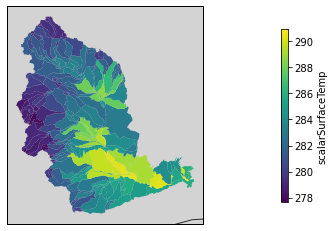

In [33]:
psp.spatial(yakima_ds['scalarSurfaceTemp'].mean(dim='time'), gdf)